# Data cleaning

In [1]:
# We will start by loading and inspecting the training and testing datasets to understand their structure.
import pandas as pd

# File paths
training_data_path = 'Classification_training_data.csv'
testing_data_path = 'Classification_testing_data.csv'

# Loading the datasets
training_data = pd.read_csv(training_data_path)
testing_data = pd.read_csv(testing_data_path)

# Displaying the first few rows of each dataset for inspection
training_data.head(), testing_data.head()
# Data Pre-processing: Step 1 - Data Cleaning

# Checking for missing values in the training and testing datasets
missing_values_train = training_data.isnull().sum()
missing_values_test = testing_data.isnull().sum()

# Displaying the number of missing values in each column (if any)
missing_values_train_summary = missing_values_train[missing_values_train > 0]
missing_values_test_summary = missing_values_test[missing_values_test > 0]
missing_values_train_summary, missing_values_test_summary
# Data Pre-processing: Step 2 - Feature Selection

# Inspecting the columns to identify irrelevant or redundant features
columns = training_data.columns

# Identifying categorical and numerical columns
categorical_columns = training_data.select_dtypes(include=['object']).columns
numerical_columns = training_data.select_dtypes(exclude=['object']).columns

# Displaying the categorical and numerical columns
categorical_columns, numerical_columns, columns


(Index(['site', 'sid', 'leaktype'], dtype='object'),
 Index(['Unnamed: 0', 'ldate', 'lrate', 'llevel', '0HZ', '10HZ', '20HZ', '30HZ',
        '40HZ', '50HZ',
        ...
        'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17',
        'MAX18', 'MAX19'],
       dtype='object', length=537),
 Index(['Unnamed: 0', 'site', 'sid', 'ldate', 'lrate', 'llevel', 'leaktype',
        '0HZ', '10HZ', '20HZ',
        ...
        'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17',
        'MAX18', 'MAX19'],
       dtype='object', length=540))

# Feature selection

In [2]:
# Data Pre-processing: Feature Selection - Removing and Assessing Columns

# Removing 'Unnamed: 0' column
training_data = training_data.drop('Unnamed: 0', axis=1)
testing_data = testing_data.drop('Unnamed: 0', axis=1)

# Assessing the number of unique values in 'site' and 'sid' columns
unique_sites_train = training_data['site'].nunique()
unique_sids_train = training_data['sid'].nunique()

unique_sites_test = testing_data['site'].nunique()
unique_sids_test = testing_data['sid'].nunique()

(unique_sites_train, unique_sids_train), (unique_sites_test, unique_sids_test)


((48, 2200), (42, 1427))

# Designing the classification model

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
# Data Pre-processing: Removing 'sid' and Handling Categorical Data
# Removing 'sid' column
training_data = training_data.drop('sid', axis=1)
testing_data = testing_data.drop('sid', axis=1)
# Converting 'site' to numerical format using one-hot encoding
training_data = pd.get_dummies(training_data, columns=['site'])
testing_data = pd.get_dummies(testing_data, columns=['site'])
# Ensuring that both datasets have the same set of columns after one-hot encoding
training_data, testing_data = training_data.align(testing_data, join='inner', axis=1)
# Separating features and target variable
X_train = training_data.drop('leaktype', axis=1)
y_train = training_data['leaktype']
X_test = testing_data.drop('leaktype', axis=1)
y_test = testing_data['leaktype']
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Displaying the shape of the processed datasets to confirm successful transformation
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape
# Range of 'k' values to try for finding the optimal 'k'
k_values = range(1, 11)
# Dictionary to store cross-validation scores for each 'k'
cv_scores = {}
# Performing cross-validation for each value of 'k'
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores[k] = np.mean(scores)
# Finding the optimal 'k' with the highest cross-validation accuracy
best_k = max(cv_scores, key=cv_scores.get)
best_score = cv_scores[best_k]
best_k, best_score
# Initializing the KNN classifier with k = 5
knn_default = KNeighborsClassifier(n_neighbors=5)
# Training the model on the entire training dataset
knn_default.fit(X_train_scaled, y_train)


KNeighborsClassifier()

# Model Evaluation

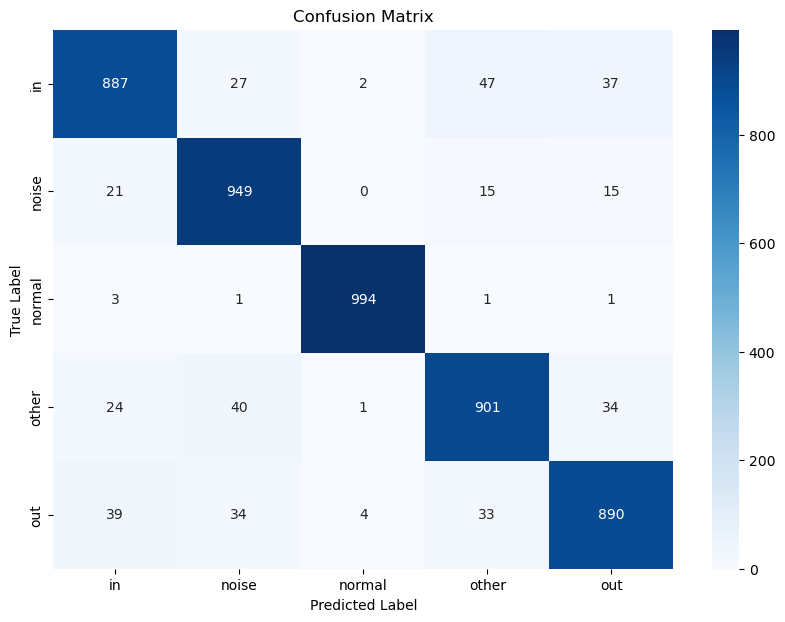

Accuracy: 92.42%
Precision: ['91.07%', '90.29%', '99.30%', '90.37%', '91.10%']
Recall: ['88.70%', '94.90%', '99.40%', '90.10%', '89.00%']


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Model Evaluation: Batch Prediction Approach
y_pred = knn_default.predict(X_test_scaled)
def batch_predict(classifier, X, batch_size=500):
    """Predict labels in batches to avoid memory issues."""
    num_samples = X.shape[0]
    predictions = np.empty(num_samples, dtype=object)
    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        batch_predictions = classifier.predict(X[start:end])
        predictions[start:end] = batch_predictions
    return predictions
# Performing batch predictions on the testing dataset
y_pred_batch = batch_predict(knn_default, X_test_scaled)
# Defining the confusion_matrix function
def confusion_matrix(actual, predicted):
    classes = np.unique(actual)
    matrix = np.zeros((len(classes), len(classes)), dtype=np.int64)
    for i in range(len(classes)):
        for j in range(len(classes)):
            matrix[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))
    return matrix
#Function to calculate accuracy, precision, and recall from the confusion matrix
def performance_metrics(cm):
    # Accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    # Precision and Recall for each class
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    return accuracy, precision, recall
# Calculating the confusion matrix and performance metrics using the batch predictions
cm_batch = confusion_matrix(y_test, y_pred_batch)
accuracy_batch, precision_batch, recall_batch = performance_metrics(cm_batch)
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
# Plotting the confusion matrix
plot_confusion_matrix(cm_batch, classes=np.unique(y_test))
# Printing accuracy, precision, and recall in percentages
print("Accuracy: {:.2f}%".format(accuracy_batch * 100))
print("Precision: {}".format(["{:.2f}%".format(p * 100) for p in precision_batch]))
print("Recall: {}".format(["{:.2f}%".format(r * 100) for r in recall_batch]))

